# Proyecto final - Conteo de granos mediante visión por comptuadora
## Text Mining & Image Recognition, Seccion L
### David Tejeda - 9170350
### Juan Hernández - 9710120
### Mario Tabarini - 22000349

In [268]:
# Se importan librerías necesarias para análisis de imagenes y manipulación de datos
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from skimage import filters, feature, measure, color
from skimage.segmentation import watershed

In [269]:
def show(image,x=30,y=10): # Función para automatizar la impresión de imagenes
  plt.figure(figsize=(x,y))
  plt.imshow(image,cmap="gray")

### Importación de imagen original

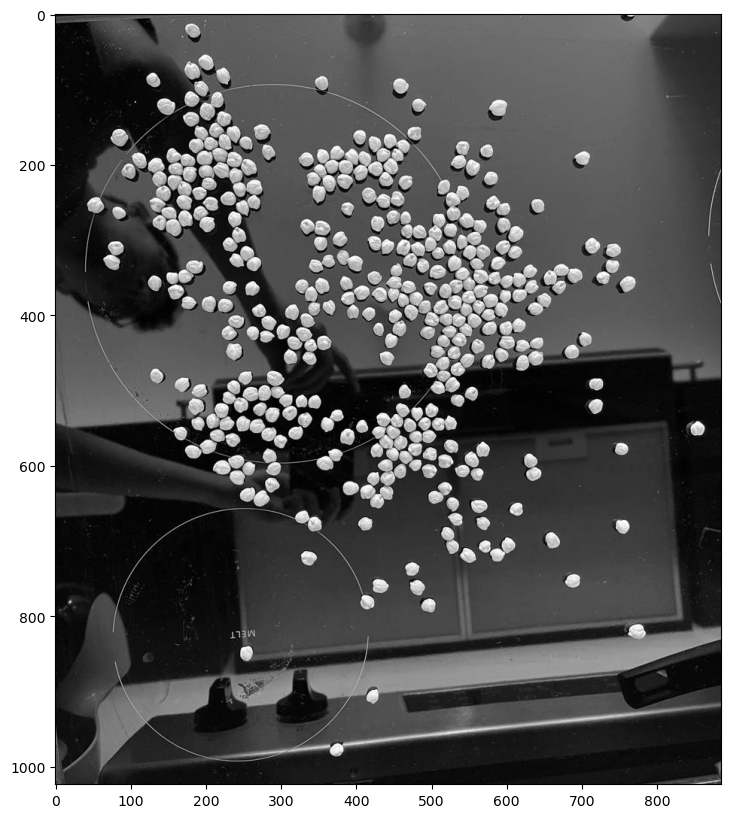

In [270]:
img_color = cv2.imread('garbanzos.jpeg') # Se importa imagen en escala de grises
image = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

show(image)


### Pre-procesamiento de la imagen

### Umbralización

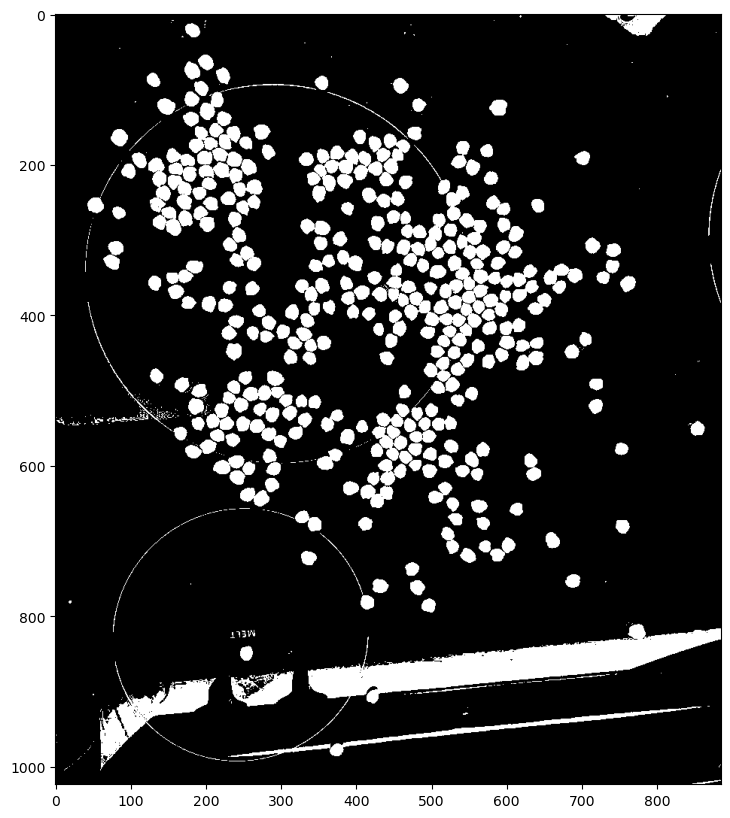

In [271]:
th, thresh_img = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY) # Se binariza la imagen 
show(thresh_img)

### Remoción de ruido mediante erosión y dilatación

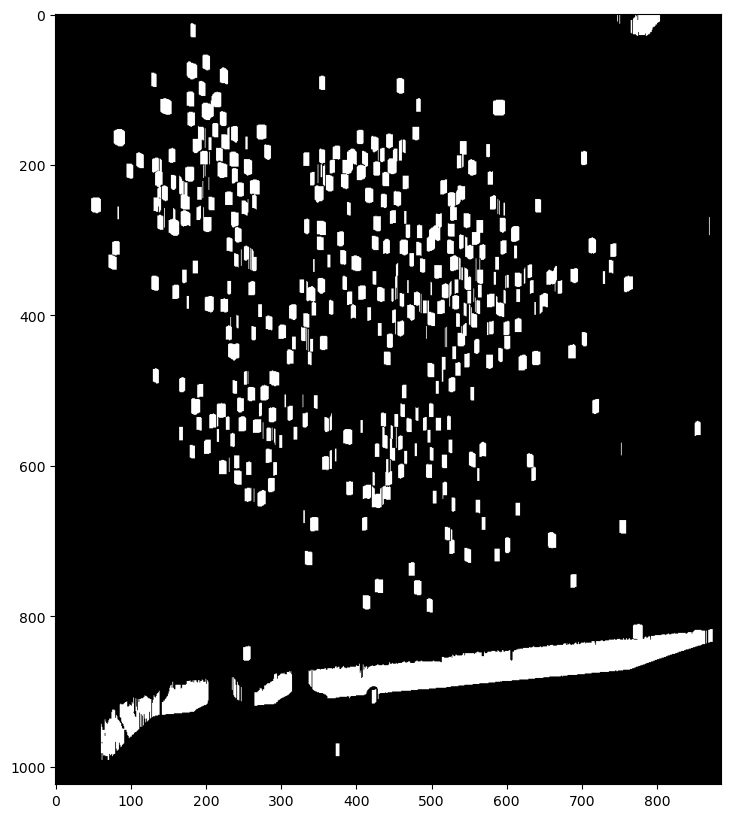

In [272]:
kernel = np.ones((3),np.uint8) # Se divide la imagen en un kernel de tres columnas y una fila
clear_image = cv2.morphologyEx(thresh_img,cv2.MORPH_OPEN, kernel, iterations=8) # Función que permite erosionar la imagen y dilatarla, en 8 iteraciones para eliminar ruido

show(clear_image)


### Determinación de contornos y conteo de granos

El número de granos es: 380


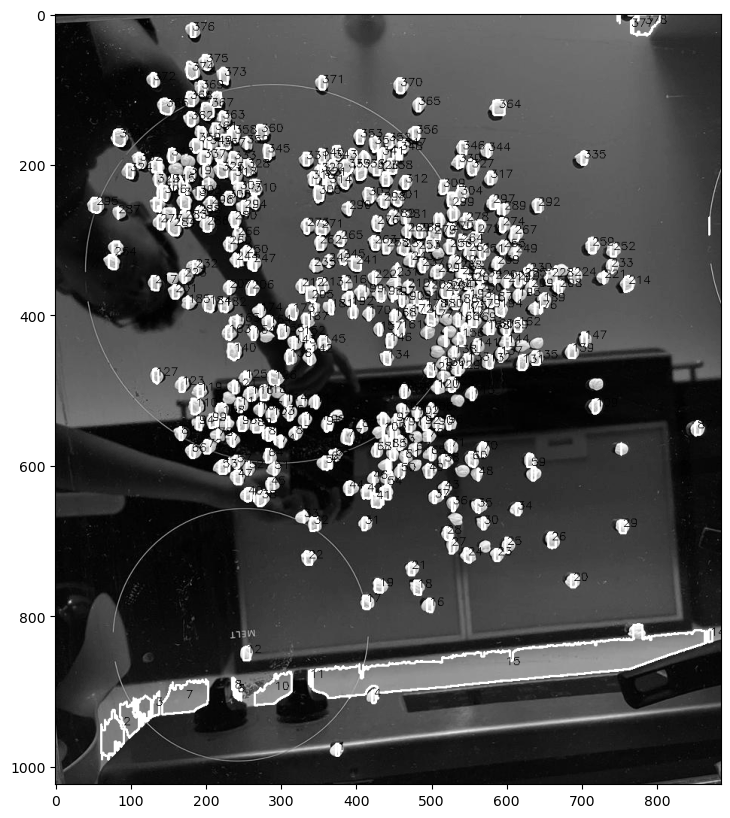

In [273]:
contours, hierarchy = cv2.findContours(clear_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # Se determinan los contornos externos (RETR_EXTERNAL) para contar granos

img_copy = image.copy() # Se hace copia de la imagen para no afectar la original
img=cv2.drawContours(img_copy, contours, -1, (255, 0, 0), 2) # Se dibujan contornos sobre imagen nueva

font = cv2.FONT_HERSHEY_SIMPLEX
for i, c in enumerate(contours): # Ciclo para asignar número a cada grano de arroz
    area = cv2.contourArea(c) # Cálculo del área del contorno
    if area > 0:
        M = cv2.moments(c) # Se determina el centroide del contorno
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
        cv2.putText(img_copy, str(i+1), (cx, cy), font, 0.5, (0, 0, 255), 1)  # Se escribe el número en el centroide

show(img_copy) # Se muestra la imagen con sus contornos y números

print(f'El número de granos es: {len(contours)}') # Se indica la cantidad de granos determinada

### Solución a detección de granos en contacto mediante algoritmo WaterShed

In [274]:
dist_trans = ndimage.distance_transform_edt(clear_image) # Se aplica función para computar la distancia entre puntos no-negativos (que no son el background de la imagen) al negativo/background más cercano
 
local_max = feature.peak_local_max(dist_trans, min_distance=11) # Se aplica función peak_local_max para obtener las coordenadas de los valores máximos locales de la imagen. El parámetro min_distance=11 se determinó de forma empírica, indica una distancia mínima entre máximos de 11 pixeles


local_max_mask = np.zeros(dist_trans.shape, dtype=bool) # Se marcan los máximos locales detectados en dist_trans como valores true y todos los demás valores como false
local_max_mask[tuple(local_max.T)] = True

labels = watershed(-dist_trans, measure.label(local_max_mask), mask=clear_image) # Se aplica algoritmo watershed con base en la imagen original y los máximos locales determinados para separar los granos pegados


#### Impresión de imagen coloreada para cada label obtenido de WaterShed

El número de granos es: 396


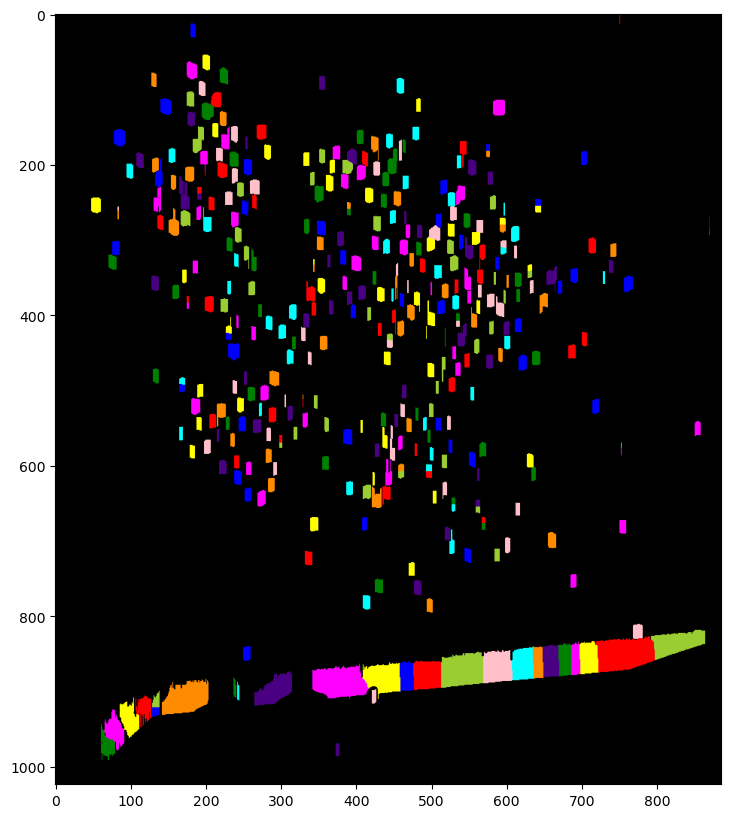

In [275]:
plt.figure(figsize=(30,10))
plt.imshow(color.label2rgb(labels, bg_label=0))
print("El número de granos es: %d" % labels.max())